In [28]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import KMeans
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
DIR_DATASET = "./data_set/"

In [2]:
filename = "N-CMAPSS_DS01-005.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (7641868, 4)
X_s shape: (7641868, 14)
X_v shape: (7641868, 14)
T shape: (7641868, 10)
A shape: (7641868, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


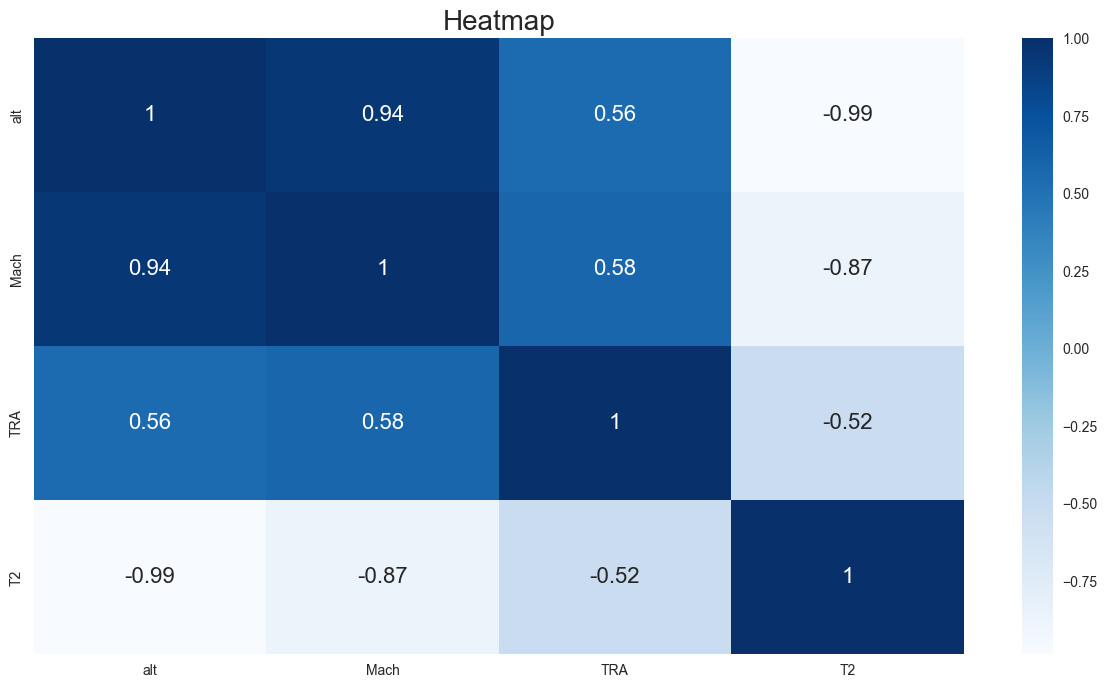

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,618.288596,1470.469798,1849.620676,1269.275585,19.432070,14.484611,19.727990,24.410990,394.701872,401.205188,15.974771,2142.253462,8693.176503,4.621622,1.0,3013.0,0.376362,70.311996,522.314770
1,618.296355,1470.415593,1849.519871,1269.177159,19.431385,14.484683,19.727295,24.410483,394.629899,401.132851,15.970518,2142.218596,8693.000298,4.620561,1.0,3020.0,0.376866,70.311996,522.327145
2,618.336514,1470.453853,1849.566139,1269.167353,19.435163,14.488224,19.731130,24.415476,394.667850,401.171401,15.969419,2142.257956,8693.106262,4.621064,1.0,3025.0,0.377685,70.311996,522.371840
3,618.302173,1470.650929,1850.195069,1269.518670,19.426003,14.477632,19.721830,24.406544,394.773533,401.272707,15.967762,2142.794673,8693.680367,4.624305,1.0,3035.0,0.376992,70.399887,522.282418
4,618.345228,1470.640421,1849.950988,1269.253972,19.427484,14.478114,19.723334,24.410159,394.732158,401.234620,15.962571,2143.015150,8693.714825,4.622768,1.0,3043.0,0.377622,70.399887,522.300605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7641863,569.171314,1262.152711,1505.220656,1142.358688,16.327415,14.032529,16.576056,18.692318,225.954240,230.620941,14.255220,1596.571022,7985.475267,2.174156,10.0,3018.0,0.310653,26.367001,517.710478
7641864,569.152102,1262.138240,1505.152347,1142.334251,16.325787,14.030423,16.574404,18.690493,225.950147,230.617148,14.256880,1596.577489,7985.456042,2.173944,10.0,3014.0,0.309960,26.367001,517.681857
7641865,569.173286,1262.180290,1505.292305,1142.446055,16.329035,14.033521,16.577700,18.693991,225.991428,230.658479,14.259194,1596.552581,7985.560636,2.174648,10.0,3010.0,0.310149,26.367001,517.707243
7641866,569.178315,1262.202029,1505.274693,1142.442261,16.330290,14.034248,16.578975,18.695488,226.017333,230.685275,14.261579,1596.586737,7985.651661,2.174786,10.0,3005.0,0.309834,26.367001,517.706106


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06,7.641868e+06
mean,5.700800e+02,1.331124e+03,1.641032e+03,1.130815e+03,1.301612e+01,1.016245e+01,1.321434e+01,1.604072e+01,2.376715e+02,2.418985e+02,1.015644e+01,1.956380e+03,8.239136e+03,2.551976e+00,5.562970e+00,1.544773e+04,5.353819e-01,6.029180e+01,4.907944e+02
std,2.089620e+01,6.831936e+01,1.241866e+02,6.234881e+01,2.853613e+00,2.399759e+00,2.897069e+00,3.415291e+00,5.878148e+01,5.960260e+01,2.733783e+00,1.881393e+02,2.269084e+02,7.847979e-01,2.869946e+00,8.002192e+03,1.192668e-01,1.843152e+01,1.960963e+01
min,4.841972e+02,1.069545e+03,9.550565e+02,6.984278e+02,5.917596e+00,4.373175e+00,6.007711e+00,6.914424e+00,8.033988e+01,8.210175e+01,4.129309e+00,1.469805e+03,7.370761e+03,3.358456e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02
25%,5.552802e+02,1.284772e+03,1.555188e+03,1.087102e+03,1.055693e+01,8.037969e+00,1.071769e+01,1.327826e+01,1.939381e+02,1.975614e+02,7.710327e+00,1.837300e+03,8.085288e+03,1.993130e+00,3.000000e+00,8.953000e+03,4.415040e-01,4.658170e+01,4.748239e+02
50%,5.677856e+02,1.326668e+03,1.649598e+03,1.121032e+03,1.326842e+01,1.046063e+01,1.347047e+01,1.605698e+01,2.251968e+02,2.295155e+02,1.034430e+01,2.002086e+03,8.231132e+03,2.341494e+00,5.000000e+00,1.396800e+04,5.435640e-01,6.424759e+01,4.952286e+02
75%,5.835877e+02,1.370427e+03,1.719504e+03,1.165601e+03,1.524554e+01,1.205116e+01,1.547771e+01,1.842790e+01,2.711389e+02,2.758910e+02,1.225378e+01,2.117207e+03,8.373454e+03,2.942434e+00,8.000000e+00,2.203700e+04,6.365520e-01,7.690375e+01,5.067949e+02
max,6.340001e+02,1.526507e+03,1.986323e+03,1.357899e+03,2.044808e+01,1.568410e+01,2.075948e+01,2.642255e+01,4.485142e+02,4.553962e+02,1.672470e+01,2.285550e+03,8.867376e+03,5.590141e+00,1.000000e+01,3.503300e+04,7.492590e-01,8.876890e+01,5.343834e+02


4.970583232360469e-16 1.0000000000000013
(7641868, 18)


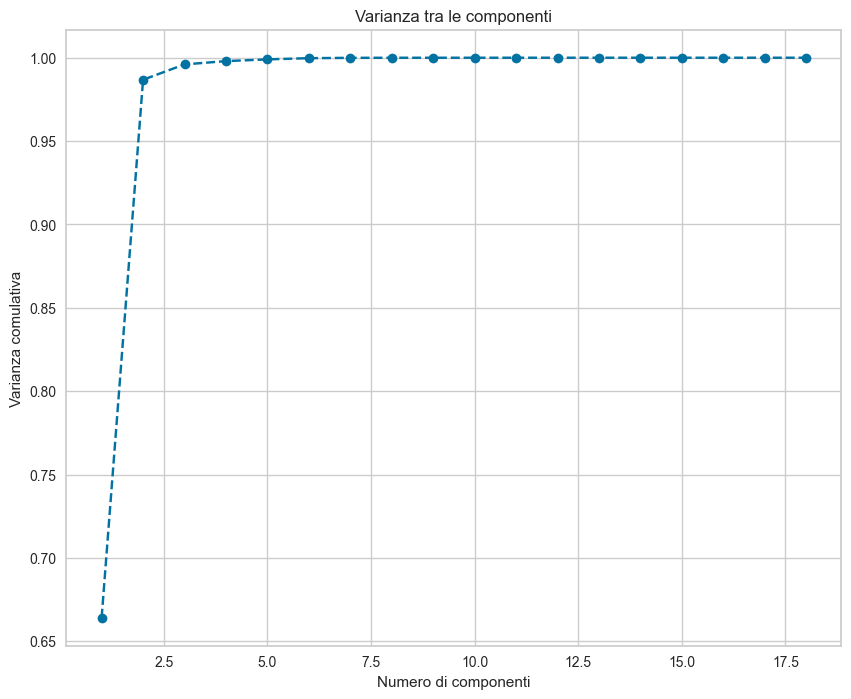

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
# wcss = []
# for i in range(1,10):
#      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
#      kmeans_pca.fit(scores_pca)
#      wcss.append(kmeans_pca.inertia_)
#      print("it",str(i))
# plt.figure(figsize=(10,8))
# plt.plot(range(1,10),wcss,marker='o',linestyle='--')
# plt.title('K-Means utilizzando PCA')
# plt.xlabel('Numero di cluster')
# plt.ylabel('WCSS')
#kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",3)
kmeans_pca = KMeans.KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)


KeyboardInterrupt



In [11]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-1.8299271941519507e-15 0.9999999999999972
(2400709, 19)
-1.1274783362514965e-15 1.0000000000000018
(3081409, 19)
5.83482676939317e-16 1.0000000000000016
(2159750, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,594.760358,1406.120452,1761.094146,1202.928634,15.642760,11.807821,15.880975,19.621618,308.153938,313.323369,12.386605,2078.855927,8485.563631,3.490936,5.446170,10160.040412,0.476698,68.228510,504.775251,0.0
mean,555.377869,1313.937297,1639.089719,1095.158350,10.124773,7.649507,10.278957,12.795698,197.525105,200.869880,7.358592,2028.474620,8188.899444,2.130402,5.736492,23881.629916,0.649998,70.658758,470.193388,1.0
mean,563.622253,1272.280594,1510.345023,1101.528574,14.221642,11.918849,14.438215,16.690140,216.604117,221.042158,11.669266,1717.378349,8036.891134,2.109735,5.445228,9292.341557,0.437084,36.678614,504.645930,2.0


Text(0, 0.5, 'Flight Class # [-]')

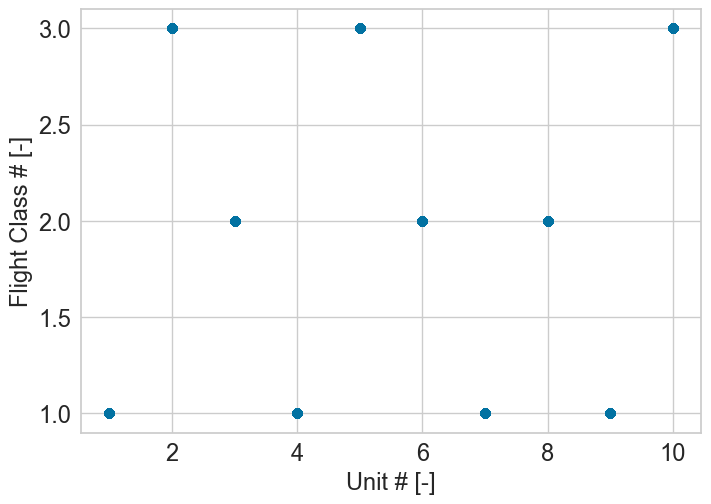

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [67]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 1, 2: 3, 3: 2, 4: 1, 5: 3, 6: 2, 7: 1, 8: 2, 9: 1, 10: 3}

In [ ]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

In [ ]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0     1.0     837840
1     2.0     776035
2     3.0     516525
totale cluster 0 : 2130400
cluster 1
   Classe  Conteggio
0     3.0    1365997
1     2.0    1015484
2     1.0       7543
totale cluster 1 : 2389024
cluster 2
   Classe  Conteggio
0     1.0     746382
1     2.0     738679
2     3.0     446713
totale cluster 2 : 1931774


In [ ]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [ ]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 15138.0
max: 29023.0


In [ ]:
df_segm_pca_kmeans['cycle'] = df_A['cycle'].values
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    if filter_cluster['alt'].min() >= 10000:
        print('Saving Cluster',i)
        filename_out = filename.replace('.h5','')
        filename_out += "_clr_" + str(i) + ".csv"
        df_X_s_u_c_mean = filter_cluster.groupby(['unit', 'cycle']).mean()
        df_X_s_u_c_mean = pd.DataFrame(df_X_s_u_c_mean).reset_index()
        df_X_s_u_c_mean.to_csv("./dataset_csv/"+filename_out,index=False)